# Fig 2: Genetic robustness determines the rate of accumulation of genetic incompatibilities in a holey fitness landscape

Russian roulette model under the Weak Mutation regime.


In [1]:
run RR_weak_mutation.py

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import t

In [3]:
sns.set(style="ticks", context='poster')
mpl.rcParams['font.family'] = 'Arial'

## Simulations

This code generates the raw data to make Fig 2.

Parameters:

* $L = 30$ diallelic loci determining fitness.

* Genotypes are viable with probability $p = 0.3, \ldots 0.9$.

* Populations diverge until they differ at $k = 15$ loci.  (But data for $k >
  12$ are discarded.)

In [4]:
def simulate(L, p, dmax, blind):
    '''Simulate population divergence under the Russian roulette model and weak
    mutation regime until a target Hamming distance between populations is reached.

    Parameters
    ----------
    L : int
        Sequence lengeth.
    p : float
        Probability that a genotype is viable.
    dmax : int
        Target Hamming distance between populations.
    blind : bool
        Whether to conduct a "blind ant" random walk.

    Returns
    -------
    pandas DataFrame
        Summary statistics.
    '''
    %run RR_weak_mutation
    z = Genotype.random_viable(L, p)
    pop = Population(z)
    orr = Orr(pop.current)
    while orr.dist < dmax:
        orr.substitute(blind)
    data = orr.get_stats()
    return data

In [17]:
%%time
%run RR_weak_mutation
L = 30
nreps = 1000
dmax = 15
for p in np.arange(.3, .91, .2).round(1):
    nus = []
    data = simulate(L, p, dmax, True)    
    data['rep'] = 0
    for i in range(1, nreps):
        tmp = simulate(L, p, dmax, True)   
        tmp['rep'] = i
        data = pd.concat((data, tmp))
    data.to_csv('raw_data/Fig2_p={0}.csv'.format(p))
    print(p)

0.3
0.5
0.7
0.9
CPU times: user 1min 47s, sys: 24.7 s, total: 2min 12s
Wall time: 2min 13s


## Fig 2

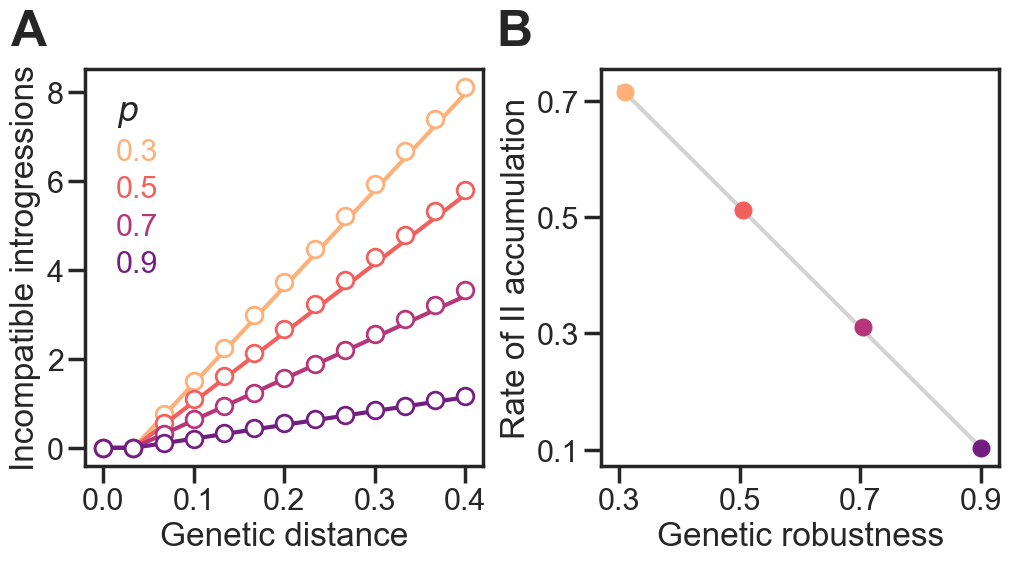

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout=True)
L = 30
nreps = 1000
cols = sns.color_palette("magma_r", 5)
i = 0
pp = np.arange(.3, .91, .2).round(1)
pptilde = (pp * L - 1) / (L - 1)
ax2.plot(pp, 1 - pptilde, 'lightgray')
for p in pp:
    data = pd.read_csv('raw_data/Fig2_p={0}.csv'.format(p), index_col=0)
    data = data.loc[data['d12'] < 13] 
    data['II'] = (data['II1'] + data['II2']) / 2
    data['nu'] = (data['nu1'] + data['nu2']) / 2
    gdata = data.groupby(['rep', 'd12'], as_index=False).mean()
    b = []
    nu = []
    for j in range(nreps):
        x = gdata.loc[gdata['rep']==j,'d12']
        y = gdata.loc[gdata['rep']==j,'II']
        slope, a, c, d, e = linregress(x, y)
        b.append(slope)
        nu.append(gdata.loc[gdata['rep']==j,'nu'].mean())
    b = np.array(b)
    nu = np.array(nu)
    ax2.plot([nu.mean()], [b.mean()], 'o', color=cols[i])
    ggdata = gdata.groupby(['d12'], as_index=False).mean()
    ggdata_std = gdata.groupby('d12', as_index=False).std()
    ggdata_std = ggdata_std.loc[ggdata_std['d12'] < 13] 
    ggdata['II_ci'] = t.ppf(.975, nreps-1) * ggdata_std['II'] / np.sqrt(nreps)
    ggdata['nu_ci'] = t.ppf(.975, nreps-1) * ggdata_std['nu'] / np.sqrt(nreps)
    ptilde = (p * L - 1) / (L - 1)
    ggdata['II_exp'] = (ggdata['d12'] - 1) * (1 - ptilde)
    ggdata.loc[ggdata['d12']==0, 'II_exp'] = 0
    ax1.plot(ggdata['d12'] / L, ggdata['II_exp'], color=cols[i], linewidth=3)
    ax1.plot(ggdata['d12'] / L, ggdata['II'], 'o', color=cols[i], markerfacecolor='w', markeredgewidth=2, label=p)
    i += 1
ax1.set_xlabel('Genetic distance')
ax1.set_ylabel('Incompatible introgressions')
ax2.set_xlabel('Genetic robustness')
ax2.set_ylabel('Rate of II accumulation')
ax1.set_yticks(np.arange(0, 9, 2))
ax1.legend(title=r'$\;\; p$', labelspacing=.3, loc='upper left', bbox_to_anchor=(-0.085, 1.0), handletextpad=0.4, handlelength=0.8, 
    frameon=False, markerscale=0, labelcolor='linecolor')
ax1.set_xticks([0, .1, .2, .3, .4])
ax2.set_xticks([.3, .5, .7, .9])
ax2.set_yticks([.1, .3, .5, .7])
ax1.text(-.187, 1.15, 'A', ha='left', va='top', size=36, weight='bold', transform=ax1.transAxes)
ax2.text(-.262, 1.15, 'B', ha='left', va='top', size=36, weight='bold', transform=ax2.transAxes)
plt.savefig('Fig2.pdf');